In [1]:
%load_ext autoreload
%autoreload 2

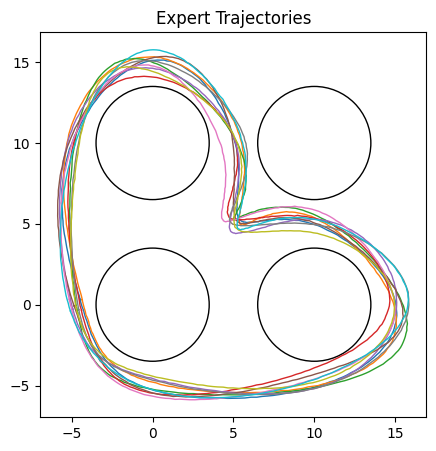

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from ese200.trajectories import plot_obstacles
from ese200.config import Config

config = Config()
data_path = Path("../data")

x_expert = np.load(data_path / "states.npy")
u_expert = np.load(data_path / "inputs.npy")

plt.figure(figsize=(10, 5))
plt.gca().set_aspect("equal")
plot_obstacles(plt.gca())
plt.title("Expert Trajectories")
for x_ in x_expert:
    plt.plot(x_[:, 0], x_[:, 1], "-", linewidth=1.0)


In [61]:
import torch
import torch.nn as nn

n_steps = 10000
lr = 1e-3
l1_weight = 1e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.from_numpy(np.load(data_path / "states.npy")).to(device).float()
u = torch.from_numpy(np.load(data_path / "inputs.npy")).to(device).float()

n_states = x.shape[-1]
n_inputs = u.shape[-1]

A = torch.zeros(n_states, n_states, device=device, requires_grad=True)
B = torch.zeros(n_states, n_inputs, device=device, requires_grad=True)

optimizer = torch.optim.Adam([A, B], lr=lr)
for i in range(n_steps):
    optimizer.zero_grad()
    x_pred = x[:, :-1] @ A.T + u[:, :-1] @ B.T
    mse_loss = (x[:, 1:] - x_pred).pow(2).mean()
    l1_loss = A.abs().mean() + B.abs().mean()
    loss = mse_loss + l1_weight * l1_loss
    loss.backward()
    optimizer.step()
    if i % (n_steps // 10) == n_steps // 10 - 1:
        print(f"MSE={mse_loss.item():.2e} | L1={l1_loss.item():.2e}")

np.save(data_path / "A.npy", A.detach().cpu().numpy())
np.save(data_path / "B.npy", B.detach().cpu().numpy())


MSE=1.46e+00 | L1=6.71e-01
MSE=2.93e-01 | L1=5.69e-01
MSE=6.61e-02 | L1=4.03e-01
MSE=5.92e-03 | L1=3.20e-01
MSE=2.96e-04 | L1=2.92e-01
MSE=1.96e-04 | L1=2.88e-01
MSE=1.96e-04 | L1=2.89e-01
MSE=1.96e-04 | L1=2.89e-01
MSE=1.96e-04 | L1=2.89e-01
MSE=1.96e-04 | L1=2.89e-01


In [63]:
A = np.load(data_path / "A.npy")
B = np.load(data_path / "B.npy")
print("A =")
print(np.array2string(A, precision=2, suppress_small=True))
print("B =")
print(np.array2string(B, precision=2, suppress_small=True))


A =
[[ 1.  -0.   0.1 -0. ]
 [ 0.   1.   0.   0.1]
 [-0.   0.   1.  -0. ]
 [-0.  -0.  -0.   1. ]]
B =
[[ 0.  -0. ]
 [ 0.   0. ]
 [ 0.1 -0. ]
 [ 0.   0.1]]


Why learn the system matrices in the first place? If we have data about expert drivers, why not simply repeat whatever inputs they made.

Let's try that. We implemented a `Simulator` class for you that you can use.

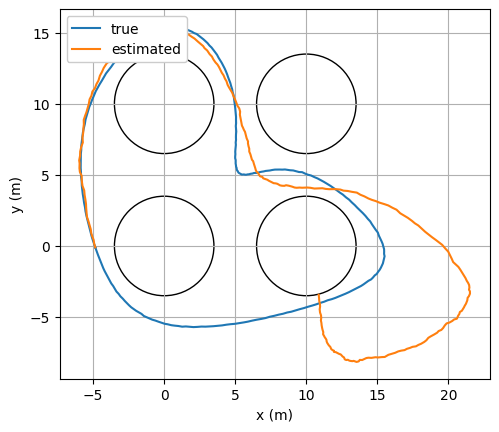

In [68]:
from ese200.trajectories import Simulator

# which trajectory we are using
trajectory_idx = 5

simulator = Simulator(config)
t = np.arange(0, config.duration, config.time_step)
x_expert = np.load(data_path / "states.npy")[trajectory_idx]
u_expert = np.load(data_path / "inputs.npy")[trajectory_idx]

x_estimate = np.zeros((len(t), A.shape[0]))
# use the starting point as the initial estimate
x_estimate[0] = x_expert[0]

# simulate the trajectory
for i in range(len(t) - 1):
    x_estimate[i + 1] = simulator.step(x_estimate[i], u_expert[i])


plt.figure()
plot_obstacles(plt.gca())
plt.grid(True)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_expert[:, 0], x_expert[:, 1], "-", label="true")
plt.plot(x_estimate[:, 0], x_estimate[:, 1], "-", label="estimated")
plt.legend(loc="upper left", framealpha=1.0)
plt.show()


Above we repeated the same inputs as the controller, but our trajectory was not the same.
For real systems, it would be impossible to replicate the same conditions. Any errors in the inputs or noise in the system accumulates over time.
However, we can use the matrices $A$ and $B$ we learnt above, to implement a _controller_ that is robust to noise.

In [77]:
import numpy.typing as npt

def calculate_reference(
        state: npt.NDArray[np.floating],
        x_expert: npt.NDArray[np.floating],
        u_expert: npt.NDArray[np.floating],
        horizon=8,
    ):
    # find the nearest point in the expert trajectory based on position
    nearest_idx = np.argmin(np.linalg.norm(x_expert[:, :2] - state[:2], axis=1))
    ref_idx = np.arange(nearest_idx, nearest_idx + horizon + 1) % len(x_expert)
    return x_expert[ref_idx], u_expert[ref_idx]

def mpc_controller(
    state: npt.NDArray[np.floating],
    state_matrix: npt.NDArray[np.floating],
    input_matrix: npt.NDArray[np.floating],
    x_ref: npt.NDArray[np.floating],
    u_ref: npt.NDArray[np.floating],
    input_penalty=1e-2,
):
    """MPC controller.

    Args:
        x: (4,) array with current state
        A: (4,4) array with state matrix
        B: (4,2) array with input matrix
    
    Returns:
        u: (M,) array with control input
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    A = torch.from_numpy(state_matrix).to(device)
    B = torch.from_numpy(input_matrix).to(device)

    x_ref_tensor = torch.tensor(x_ref, device=device).float()
    u_ref_tensor = torch.tensor(u_ref, device=device).float()
    
    # initialize x and u to the reference trajectory
    x0 = torch.tensor(state, device=device).float()
    u = u_ref_tensor.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([u], lr=1.0)

    for _ in range(20):
        optimizer.zero_grad()
        loss = torch.zeros(1, device=device)
        xs = [x0]
        for i in range(len(x_ref) - 1):
            xs.append(xs[-1] @ A.T + u[i] @ B.T)
            loss += (xs[-1] - x_ref_tensor[i + 1]).pow(2).sum()
        
        loss += input_penalty * u.pow(2).sum()  # penalize control inputs

        # penalize equality constraints more than reference trajectory
        loss.backward()
        optimizer.step()
    return u.detach().cpu().numpy()[0]

100%|██████████| 299/299 [00:22<00:00, 13.28it/s]


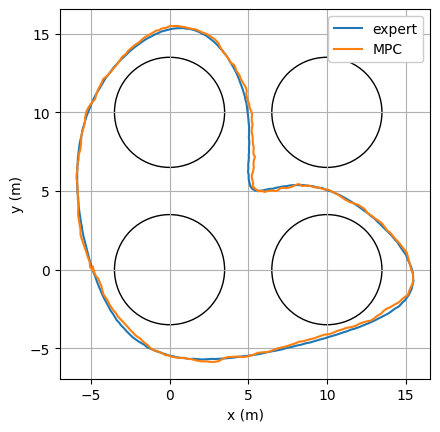

In [87]:
from tqdm import trange
# simulate the trajectory

t = np.arange(0, config.duration, config.time_step)
x_mpc = np.zeros((len(t), A.shape[0]))
# use the same starting point as the expert
x_mpc[0] = x_expert[0]

for i in trange(len(t) - 1):
    x_ref, u_ref = calculate_reference(x_mpc[i], x_expert, u_expert, horizon=8)
    u = mpc_controller(x_mpc[i], A, B, x_ref, u_ref)
    x_mpc[i + 1] = simulator.step(x_mpc[i], u)

plt.figure()
plot_obstacles(plt.gca())
plt.grid(True)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(
    x_expert[:, 0], x_expert[:, 1], "-", label="expert"
)
plt.plot(
    x_mpc[:, 0],
    x_mpc[:, 1],
    "-",
    label="MPC",
)
plt.legend(loc="upper right", framealpha=1.0)
plt.show()


In [88]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

trail_length = 10

plt.figure()
plt.ion()
plot_obstacles(plt.gca())
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(
    x_expert[:, 0], x_expert[:, 1], "--", label="expert"
)
trail = plt.plot([], [], "-", c="orange", label="MPC")[0]
current_position = plt.plot([], [], "o", c="orange")[0]
plt.legend(loc="upper right", framealpha=1.0)

def animate(i: int):
    trail_idx = slice(max(i-trail_length, 0), i)
    trail.set_data(x_mpc[trail_idx, 0], x_mpc[trail_idx, 1])
    current_position.set_data([x_mpc[i, 0]], [x_mpc[i, 1]])
    


# html5 video
ani = FuncAnimation(plt.gcf(), animate, frames=len(t), interval=100)
display(HTML(ani.to_html5_video()))
plt.close()